# Ride Hailing Apps Pricing Analysis and Prediction

## Estimating the cost for a Cab ride 
--------------

## Data
### *'cab_rides.csv'* - Cab Details 
### *'weather.csv'* - Weather Details 
------------------------------------------

#### Importing SQLite & Create Functions used for Normalized database 

In [1]:
# Load the necessary libraries.
import sqlite3

In [2]:
### Utility Functions
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
# Delete old database file
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename, delete_db = True)

In [4]:
conn = create_connection(normalized_database_filename)
cur = conn.cursor()

### Create tables & Insert Values into the Tables 

#### *1. Location Table*

In [5]:
# Create table statement
table_location = """CREATE TABLE [Location] (
    [Location_ID] INTEGER NOT NULL PRIMARY KEY,
    [Location] TEXT NOT NULL
    );"""
    
with conn:
    create_table(conn, table_location)

location = []
a = 0

# Loading data
with open('cab_rides.csv') as file:
    for line in file:
        if a > 0:
            row = line.split('\t')[0].strip().split(',')
            location.append((row[3],))
            location.append((row[4],))
        a += 1

location_sorted = sorted(list(set(location)))

# Inserting values into table
cur.executemany("""INSERT INTO Location (Location) VALUES (?)""", location_sorted)
conn.commit()

In [6]:
# Data Check
import pandas as pd
df_location = pd.read_sql_query("""SELECT * FROM Location""", conn)
print(df_location.shape)

(12, 2)


In [7]:
df_location

,Location_ID,Location
0,1,Back Bay
1,2,Beacon Hill
2,3,Boston University
3,4,Fenway
4,5,Financial District
5,6,Haymarket Square
6,7,North End
7,8,North Station
8,9,Northeastern University
9,10,South Station


### *2. Creating Timestamp Table*

In [8]:
from datetime import datetime
from datetime import date
import datetime

In [9]:
# Create table statement 
table_timestamp = """CREATE TABLE [Timestamp] (
    [Timestamp_ID] INTEGER NOT NULL PRIMARY KEY,
    [Date] TEXT NOT NULL,
    [Day] TEXT NOT NULL,
    [Hour] TEXT NOT NULL
    );"""
    
with conn:
    create_table(conn, table_timestamp)

ts = []
a = 0

# Load Data
with open('weather.csv') as file:
    for line in file:
        if a > 0:
            row = line.split('\t')[0].strip().split(',')
            timestamp = int(row[5])
            date_weather = datetime.datetime.fromtimestamp(timestamp)
            temp = date_weather.strftime("%Y-%m-%d %H").split(' ')
            ts.append((temp[0],
                      datetime.datetime(int(temp[0][0:4]), int(temp[0][5:7]), int(temp[0][8:10])).strftime('%A'),
                       temp[1]))
        a += 1

# insert values into table
cur.executemany("""INSERT INTO Timestamp (Date, Day, Hour) VALUES (?, ?, ?)""", ts)
conn.commit()

In [10]:
# Data Check 
df_timestamp = pd.read_sql_query("""SELECT * FROM Timestamp""", conn)
print(df_timestamp.shape)

(6276, 4)


In [11]:
df_timestamp

,Timestamp_ID,Date,Day,Hour
0,1,2018-12-16,Sunday,18
1,2,2018-12-16,Sunday,18
2,3,2018-12-16,Sunday,18
3,4,2018-12-16,Sunday,18
4,5,2018-12-16,Sunday,18
...,...,...,...,...
6271,6272,2018-12-03,Monday,01
6272,6273,2018-12-03,Monday,01
6273,6274,2018-12-03,Monday,01
6274,6275,2018-12-03,Monday,01


### *3. Creating CabType Table*

In [12]:
# Create table Statement
table_cab_type = """CREATE TABLE [CabType] (
    [CabTypeID] INTEGER NOT NULL PRIMARY KEY,
    [CabTypeName] TEXT NOT NULL
    );"""
    
with conn:
    create_table(conn, table_cab_type)

cab_type = []
a = 0

# Load Data
with open('cab_rides.csv') as file:
    for line in file:
        if a > 0:
            row = line.split('\t')[0].strip().split(',')
            cab_type.append((row[1],))
        a += 1

cab_type_sorted = sorted(list(set(cab_type)))

# Insert values into table
cur.executemany("""INSERT INTO CabType (CabTypeName) VALUES (?)""", cab_type_sorted)
conn.commit()

In [13]:
# Data Check
cab_type_sorted

[('Lyft',), ('Uber',)]

In [14]:
df_cab_type = pd.read_sql_query("""SELECT * FROM CabType""", conn)
print(df_cab_type.shape)

(2, 2)


In [15]:
df_cab_type

,CabTypeID,CabTypeName
0,1,Lyft
1,2,Uber


### *4. Creating CabProductType Table*

In [16]:
# Create Table Statement
table_cab_product_type = """CREATE TABLE [CabProductType] (
    [Product_ID] INTEGER NOT NULL PRIMARY KEY,
    [ProductName] TEXT NOT NULL,
    [CabTypeID] INTEGER NOT NULL,
    FOREIGN KEY(CabTypeID) REFERENCES CabType(CabTypeID)
    );"""
    
with conn:
    create_table(conn, table_cab_product_type)

cab_product_type = []
a = 0

# Loading data
with open('cab_rides.csv') as file:
    for line in file:
        if a > 0:
            row = line.split('\t')[0].strip().split(',')
            if row[1] == 'Lyft':
                cabtypeid = 1
            elif row[1] == 'Uber':
                cabtypeid = 2
            cab_product_type.append((row[9],
                                     cabtypeid
                                    ))
        a += 1

cab_product_type_sorted = sorted(list(set(cab_product_type)))

# Insert Values into the table
cur.executemany("""INSERT INTO CabProductType (ProductName, CabTypeID) VALUES (?, ?)""", cab_product_type_sorted)
conn.commit()

In [17]:
# Data Check
cab_product_type[0:10]

[('Shared', 1),
 ('Lux', 1),
 ('Lyft', 1),
 ('Lux Black XL', 1),
 ('Lyft XL', 1),
 ('Lux Black', 1),
 ('Lyft XL', 1),
 ('Lux Black', 1),
 ('Shared', 1),
 ('Lux Black XL', 1)]

In [18]:
df_cab_product_type = pd.read_sql_query("""SELECT * FROM CabProductType""", conn)
print(df_cab_product_type.shape)

(13, 3)


In [19]:
df_cab_product_type

,Product_ID,ProductName,CabTypeID
0,1,Black,2
1,2,Black SUV,2
2,3,Lux,1
3,4,Lux Black,1
4,5,Lux Black XL,1
5,6,Lyft,1
6,7,Lyft XL,1
7,8,Shared,1
8,9,Taxi,2
9,10,UberPool,2


In [20]:
product_id_dict = {df_cab_product_type['ProductName'][i]: df_cab_product_type['Product_ID'][i] for i in range(df_cab_product_type.shape[0])}
product_id_dict

{'Black': 1,
 'Black SUV': 2,
 'Lux': 3,
 'Lux Black': 4,
 'Lux Black XL': 5,
 'Lyft': 6,
 'Lyft XL': 7,
 'Shared': 8,
 'Taxi': 9,
 'UberPool': 10,
 'UberX': 11,
 'UberXL': 12,
 'WAV': 13}

### *5. Creating Weather Table*

In [21]:
# Create the dictionary for Location_ID.
location_dict = {df_location['Location'][i]: df_location['Location_ID'][i] for i in range(df_location.shape[0])}
location_dict

{'Back Bay': 1,
 'Beacon Hill': 2,
 'Boston University': 3,
 'Fenway': 4,
 'Financial District': 5,
 'Haymarket Square': 6,
 'North End': 7,
 'North Station': 8,
 'Northeastern University': 9,
 'South Station': 10,
 'Theatre District': 11,
 'West End': 12}

In [22]:
# Create the dictionary for Timestamp_ID.
timestamp_dict = {(df_timestamp['Date'][i], df_timestamp['Hour'][i]): df_timestamp['Timestamp_ID'][i] for i in range(df_timestamp.shape[0])}
timestamp_dict

{('2018-12-16', '18'): 2336,
 ('2018-11-27', '14'): 3963,
 ('2018-11-26', '19'): 6010,
 ('2018-11-28', '19'): 6079,
 ('2018-12-14', '06'): 4673,
 ('2018-11-26', '12'): 2070,
 ('2018-12-03', '04'): 2194,
 ('2018-12-15', '05'): 4094,
 ('2018-12-14', '13'): 915,
 ('2018-12-17', '12'): 92,
 ('2018-12-17', '21'): 5647,
 ('2018-12-01', '18'): 5851,
 ('2018-11-28', '04'): 6160,
 ('2018-12-15', '13'): 3449,
 ('2018-12-18', '05'): 386,
 ('2018-12-09', '21'): 5137,
 ('2018-12-14', '22'): 5446,
 ('2018-11-26', '00'): 6093,
 ('2018-11-29', '14'): 179,
 ('2018-12-13', '13'): 2727,
 ('2018-11-25', '23'): 5999,
 ('2018-11-27', '07'): 5332,
 ('2018-12-18', '02'): 202,
 ('2018-11-28', '05'): 5425,
 ('2018-12-15', '09'): 228,
 ('2018-12-16', '09'): 1119,
 ('2018-11-28', '02'): 6170,
 ('2018-12-01', '15'): 245,
 ('2018-11-27', '00'): 5768,
 ('2018-12-14', '11'): 3272,
 ('2018-11-30', '17'): 294,
 ('2018-11-28', '17'): 6034,
 ('2018-11-26', '20'): 5436,
 ('2018-12-13', '17'): 5930,
 ('2018-12-17', '01'): 

In [23]:
# Create table statement
table_weather = """CREATE TABLE [Weather] (
    [Weather_ID] INTEGER NOT NULL PRIMARY KEY,
    [Timestamp_ID] INTEGER NOT NULL,
    [Location_ID] INTEGER NOT NULL,
    [Temp] FLOAT NOT NULL,
    [Clouds] FLOAT NOT NULL,
    [Pressure] FLOAT NOT NULL,
    [Rain] FLOAT NOT NULL,
    [Humidity] FLOAT NOT NULL,
    [Wind] FLOAT NOT NULL,
    FOREIGN KEY(Location_ID) REFERENCES Location(Location_ID) FOREIGN KEY(Timestamp_ID) REFERENCES Timestamp(Timestamp_ID)
    );"""
    
with conn:
    create_table(conn, table_weather)

weather = []
a = 0

# Load Data
with open('weather.csv') as file:
    for line in file:
        if a > 0:
            row = line.split('\t')[0].strip().split(',')
            timestamp = int(row[5])
            date = datetime.datetime.fromtimestamp(timestamp)
            temp = date.strftime("%Y-%m-%d %H").split(' ')
            if row[4] == '':
                weather.append((int(timestamp_dict.get((temp[0], temp[1]))),
                                int(location_dict.get(row[1])),
                                float(row[0]),
                                float(row[2]),
                                float(row[3]),
                                float(0),
                                float(row[6]),
                                float(row[7])
                               ))
            else:
                weather.append((int(timestamp_dict.get((temp[0], temp[1]))),
                                int(location_dict.get(row[1])),
                                float(row[0]),
                                float(row[2]),
                                float(row[3]),
                                float(row[4]),
                                float(row[6]),
                                float(row[7])
                               ))
        a += 1
# Insert Values into table
cur.executemany("""INSERT INTO Weather (Timestamp_ID, Location_ID, Temp, Clouds, Pressure, Rain, Humidity, Wind) VALUES (?, ?, ?, ?, ?, ?, ?, ?)""", weather)
conn.commit()

In [24]:
# Data Check
len(weather)

6276

In [25]:
weather[0:10]

[(2336, 1, 42.42, 1.0, 1012.14, 0.1228, 0.77, 11.25),
 (2336, 2, 42.43, 1.0, 1012.15, 0.1846, 0.76, 11.32),
 (2336, 3, 42.5, 1.0, 1012.15, 0.1089, 0.76, 11.07),
 (2336, 4, 42.11, 1.0, 1012.13, 0.0969, 0.77, 11.09),
 (2336, 5, 43.13, 1.0, 1012.14, 0.1786, 0.75, 11.49),
 (2336, 6, 42.34, 1.0, 1012.15, 0.2068, 0.77, 11.49),
 (2336, 7, 42.36, 1.0, 1012.15, 0.2088, 0.77, 11.46),
 (2336, 8, 42.21, 1.0, 1012.16, 0.2069, 0.77, 11.37),
 (2336, 9, 42.07, 1.0, 1012.12, 0.102, 0.78, 11.28),
 (2336, 10, 43.05, 1.0, 1012.12, 0.1547, 0.75, 11.58)]

In [26]:
df_weather = pd.read_sql_query("""SELECT * FROM Weather""", conn)
print(df_weather.shape)

(6276, 9)


In [27]:
df_weather

,Weather_ID,Timestamp_ID,Location_ID,Temp,Clouds,Pressure,Rain,Humidity,Wind
0,1,2336,1,42.42,1.00,1012.14,0.1228,0.77,11.25
1,2,2336,2,42.43,1.00,1012.15,0.1846,0.76,11.32
2,3,2336,3,42.50,1.00,1012.15,0.1089,0.76,11.07
3,4,2336,4,42.11,1.00,1012.13,0.0969,0.77,11.09
4,5,2336,5,43.13,1.00,1012.14,0.1786,0.75,11.49
...,...,...,...,...,...,...,...,...,...
6271,6272,6276,8,44.72,0.89,1000.69,0.0000,0.96,1.52
6272,6273,6276,9,44.85,0.88,1000.71,0.0000,0.96,1.54
6273,6274,6276,10,44.82,0.89,1000.70,0.0000,0.96,1.54
6274,6275,6276,11,44.78,0.89,1000.70,0.0000,0.96,1.54


### *6. Creating RideDetail Table*

In [28]:
# Create table statement
table_ridedetail = """CREATE TABLE [RideDetail] (
    [Ride_ID] INTEGER NOT NULL PRIMARY KEY,
    [Timestamp_ID] INTEGER NOT NULL,
    [Source_ID] INTEGER NOT NULL,
    [Destination_ID] INTEGER NOT NULL,
    [CabTypeID] INTEGER NOT NULL,
    [Product_ID] INTEGER NOT NULL,
    [Distance] FLOAT NOT NULL,
    [Price] FLOAT NOT NULL,
    FOREIGN KEY(Timestamp_ID) REFERENCES Timestamp(Timestamp_ID) FOREIGN KEY(CabTypeID) REFERENCES CabType(CabTypeID) FOREIGN KEY(Product_ID) REFERENCES CabProductType(Product_ID) FOREIGN KEY(Source_ID) REFERENCES Location(Location_ID) FOREIGN KEY(Destination_ID) REFERENCES Location(Location_ID)
    );"""
    
with conn:
    create_table(conn, table_ridedetail)

ridedetail = []
a = 0

# Load Data
with open('cab_rides.csv') as file:
    for line in file:
        if a > 0:
            row = line.split('\t')[0].strip().split(',')
            timestamp = int(row[2])
            date = datetime.datetime.fromtimestamp(timestamp / 1000)
            temp = date.strftime("%Y-%m-%d %H").split(' ')
                
            if row[1] == 'Lyft':
                cabtypeid = 1
            elif row[1] == 'Uber':
                cabtypeid = 2
                
            if row[5] != '':
                try:
                    ridedetail.append((int(timestamp_dict.get((temp[0], temp[1]))),
                                       int(location_dict.get(row[4])),
                                       int(location_dict.get(row[3])),
                                       int(cabtypeid),
                                       int(product_id_dict.get(row[9])),
                                       float(row[0]),
                                       float(row[5])
                                       ))
                except:
                    pass
        a += 1

# Insert values into table
cur.executemany("""INSERT INTO RideDetail (Timestamp_ID, Source_ID, Destination_ID, CabtypeID, Product_ID, Distance, Price) VALUES (?, ?, ?, ?, ?, ?, ?)""", ridedetail)
conn.commit()

In [29]:
# Data Check
ridedetail[0:10]

[(4309, 6, 8, 1, 8, 0.44, 5.0),
 (5626, 6, 8, 1, 3, 0.44, 11.0),
 (4998, 6, 8, 1, 5, 0.44, 26.0),
 (5026, 6, 8, 1, 7, 0.44, 9.0),
 (2383, 6, 8, 1, 4, 0.44, 16.5),
 (6093, 1, 9, 1, 7, 1.08, 10.5),
 (4196, 1, 9, 1, 4, 1.08, 16.5),
 (6276, 1, 9, 1, 8, 1.08, 3.0),
 (3389, 1, 9, 1, 5, 1.08, 27.5),
 (575, 1, 9, 1, 3, 1.08, 13.5)]

In [30]:
df_ride_detail = pd.read_sql_query("""SELECT * FROM RideDetail""", conn)
print(df_ride_detail.shape)

(635242, 8)


In [31]:
df_ride_detail

,Ride_ID,Timestamp_ID,Source_ID,Destination_ID,CabTypeID,Product_ID,Distance,Price
0,1,4309,6,8,1,8,0.44,5.0
1,2,5626,6,8,1,3,0.44,11.0
2,3,4998,6,8,1,5,0.44,26.0
3,4,5026,6,8,1,7,0.44,9.0
4,5,2383,6,8,1,4,0.44,16.5
...,...,...,...,...,...,...,...,...
635237,635238,5851,12,7,2,13,1.00,9.5
635238,635239,5851,12,7,2,12,1.00,13.0
635239,635240,5851,12,7,2,11,1.00,9.5
635240,635241,5851,12,7,2,2,1.00,27.0


,Cab Type,Market Share
0,Lyft,306102
1,Uber,329140


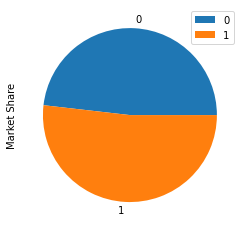

In [32]:
def market_share():
    sql_statement = """SELECT c.CabTypeName as 'Cab Type' , COUNT(r.CabTypeID) as 'Market Share' FROM ridedetail r
                                        JOIN CabType c 
                                        ON r.CabTypeID = c. CabTypeID 
                                        GROUP BY 1 """ 
    df = pd.read_sql_query(sql_statement, conn)
    display(df)
    df.plot(kind = 'pie', y = 'Market Share')

market_share()

,Location,No. of Bookings
0,Back Bay,52995
1,Beacon Hill,52675
2,Boston University,52940
3,Fenway,52933
4,Financial District,53948
5,Haymarket Square,52942
6,North End,52934
7,North Station,52322
8,Northeastern University,52913
9,South Station,52930


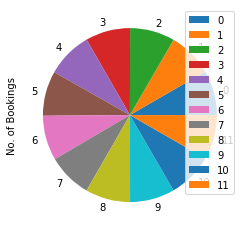

In [33]:
def pickup_locations():
    sql_statement = """SELECT loc.Location, count(r.Source_ID) as 'No. of Bookings' 
                                    from RideDetail r
                                    join Location loc
                                    on r.Source_ID = loc.Location_ID
                                    group by loc.location
                                     """ 
    df = pd.read_sql_query(sql_statement, conn)
    display(df)
    df.plot(kind = 'pie', y = 'No. of Bookings')

pickup_locations()

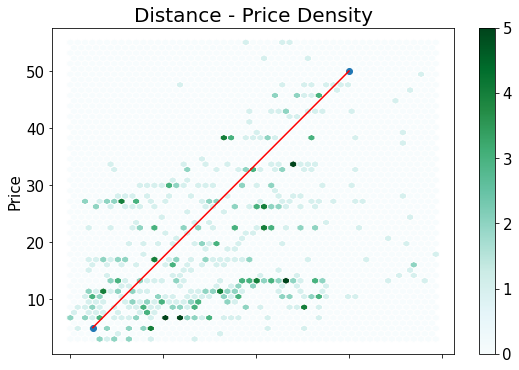

In [84]:
sql_statement = "SELECT distance,Price from RideDetail WHERE price<=60 GROUP BY distance"
df = pd.read_sql_query(sql_statement, conn)


math_plot=df.plot.hexbin(x='Distance',y='Price',color='w',figsize=(9, 6),gridsize = 50)
math_plot.set_title('Distance - Price Density',size=20)
#plt.grid()

import numpy as np
from scipy.stats import linregress

x = np.array([0.5, 6])
y = np.array([5, 50])
math_plot.plot(x, y, 'o', label='original data')
slope, intercept, r_value, p_value, std_err = linregress(x, y)
math_plot.plot(x, intercept + slope*x, 'r', label='fitted line')
#df.plot(y=[ 'Humidity','Price'],figsize=(3,7))

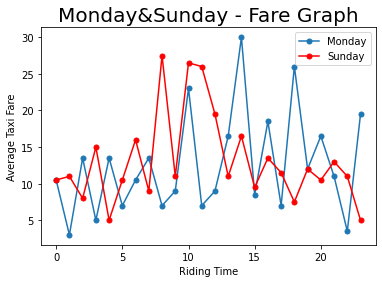

In [35]:
sql_statement = "SELECT hour,Price FROM Timestamp,RideDetail WHERE Timestamp.Timestamp_ID=RideDetail.Timestamp_ID and Day='Monday' GROUP BY Timestamp.hour"
df = pd.read_sql_query(sql_statement, conn)
#print(df.count())
#df["Hour"] = pd.to_numeric(df["Hour"])
#GROUP BY --> average value !
ax = df.plot(y=['Price'],figsize=(6, 4),  xlabel="Riding Time", ylabel="Average Taxi Fare", marker='o', ms=5)
ax.set_title("Monday&Sunday - Fare Graph", fontsize=20)

sql_statement = "SELECT hour,Price FROM Timestamp,RideDetail WHERE Timestamp.Timestamp_ID=RideDetail.Timestamp_ID and Day='Sunday' GROUP BY Timestamp.hour"

df = pd.read_sql_query(sql_statement, conn)

df2=df.plot(y=['Price'],figsize=(6, 4),  xlabel="Riding Time", ylabel="Average Taxi Fare", marker='o', ms=5,color="r",ax=ax)
#average_fare_sunday.set_title("Sunday", fontsize=20)
#df2.plot(ax=ax)
#ax
from matplotlib.pyplot import *
legend(['Monday', 'Sunday'])
#plt.show()
#Monday : 1. overall taxi fare is higher than Sunday --> Bcz There is much taxi demand on Monday.
#         2. There are  three peaks : around commuting time and lunch time --> much riding demand.

#Sunday : 1. overall taxi fare is notably lower than Monday
#         2. peak time during morning --> no higher demand at night(people wanna stay at home on sunday night!)

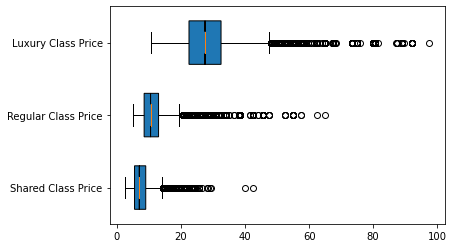

In [36]:
import matplotlib.pyplot as mpl
import numpy as np
def type_price_distribution():
    sql_statement = """SELECT cpt.ProductName, r.price
                        FROM RideDetail r
                        LEFT JOIN CabProductType cpt
                        ON r.Product_ID = cpt.Product_ID
                        
                        """
    cabs = pd.read_sql_query(sql_statement, conn)

    #display(cabs)
    price_by_shared = cabs.loc[(cabs['ProductName'].isin(['Shared','UberPool']))  ,'Price'].to_numpy()
    #return price_by_shared

    price_by_luxury = cabs.loc[(cabs['ProductName'].isin(['Lux','Lux Black XL','Black SUV'])),'Price'].to_numpy()
    price_by_shared = cabs.loc[(cabs['ProductName'].isin(['Shared','UberPool'])),'Price'].to_numpy()


    #return price_by_luxury
    price_by_regular = cabs.loc[ (cabs['ProductName'].isin(['Lyft','Lyft XL','Uber XL','UberX','WAV','Taxi']))  ,'Price'].to_numpy()
    
    prices_by_class = [price_by_shared,np.nan_to_num(price_by_regular),np.nan_to_num(price_by_luxury)]
    
    
    mpl.boxplot(prices_by_class, vert=False,widths=(0.6,0.6,0.6),notch ='True',patch_artist = True)
    mpl.yticks([1,2,3], ['Shared Class Price', 'Regular Class Price','Luxury Class Price'])
    
    
type_price_distribution()

# Building Neural Network Model for Price Prediction
--------------

### *1. Construct the Input Data*

In [37]:
sql_statement = '''SELECT Ride_ID, Price, Source_ID, Destination_ID, Distance,
CabType.CabTypeName, CabProductType.ProductName, Day, Date, Hour,
ridedetail.timestamp_id,
avg(Weather.Temp) as Temp, avg(Weather.Clouds) as Clouds, 
avg(Weather.Pressure) as Pressure, avg(Weather.Rain) as Rain
,avg(Weather.Humidity) as Humidity, avg(Weather.Wind) as Wind
FROM RideDetail 
LEFT JOIN CabType ON RideDetail.CabTypeID = CabType.CabTypeID 
LEFT JOIN CabProductType ON RideDetail.Product_ID = CabProductType.Product_ID
LEFT JOIN weather on weather.timestamp_id = ridedetail.timestamp_id
     and weather.location_id = ridedetail.source_id
LEFT JOIN Timestamp ON Ridedetail.Timestamp_ID = Timestamp.Timestamp_ID
group by 1,2,3,4,5,6,7,8,9,10,11;
'''
## The weather data is consolidated at an hourly level, so the mean of weather features within the hour is queried; 

# Reading the query output
df = pd.read_sql_query(sql_statement, conn)

In [38]:
df.drop(['Ride_ID', 'Date'], axis = 1, inplace = True)

In [39]:
import matplotlib.pyplot as plt

In [40]:
lower_bound = 0.01
upper_bound = 0.99

<function matplotlib.pyplot.show(close=None, block=None)>

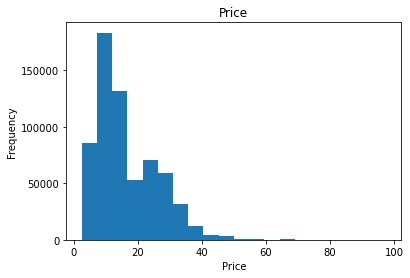

In [41]:
plt.title(r'Price')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Price'], bins = 20)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show

In [42]:
res_price = df.Price.quantile([lower_bound, upper_bound])
res_price

0.01     3.5
0.99    42.5
Name: Price, dtype: float64

In [43]:
# Remove the observations larger than upper_bound.
true_index_price = (df.Price.values < res_price.loc[upper_bound])

<function matplotlib.pyplot.show(close=None, block=None)>

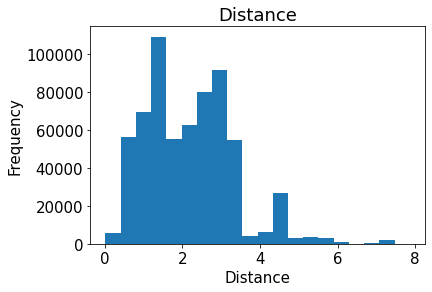

In [44]:
plt.title(r'Distance')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Distance'], bins = 20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show

In [45]:
res_distance = df.Distance.quantile([lower_bound, upper_bound])

In [46]:
# Remove the observations larger than upper_bound.
true_index_distance = (df.Distance.values < res_distance.loc[upper_bound])

<function matplotlib.pyplot.show(close=None, block=None)>

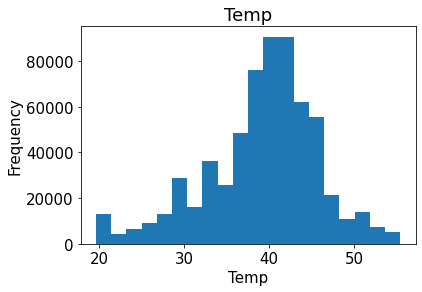

In [47]:
plt.title(r'Temp')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Temp'], bins = 20)
plt.xlabel('Temp')
plt.ylabel('Frequency')
plt.show

In [48]:
res_temp = df.Temp.quantile([lower_bound, upper_bound])

In [49]:
# Remove the observations smaller than lower bound and larger than upper_bound.
true_index_temp = (res_temp.loc[lower_bound] < df.Temp.values) & \
             (df.Temp.values < res_temp.loc[upper_bound])

<function matplotlib.pyplot.show(close=None, block=None)>

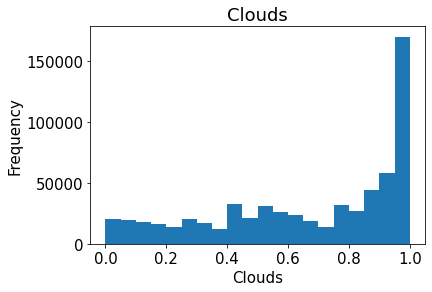

In [50]:
plt.title(r'Clouds')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Clouds'], bins = 20)
plt.xlabel('Clouds')
plt.ylabel('Frequency')
plt.show

In [51]:
res_clouds = df.Clouds.quantile([lower_bound, upper_bound])

In [52]:
# Remove the observations smaller than lower_bound.
true_index_clouds = (res_clouds.loc[lower_bound] < df.Clouds.values)

<function matplotlib.pyplot.show(close=None, block=None)>

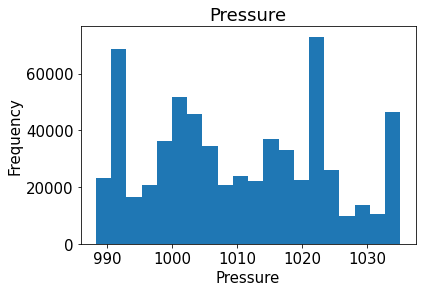

In [53]:
plt.title(r'Pressure')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Pressure'], bins = 20)
plt.xlabel('Pressure')
plt.ylabel('Frequency')
plt.show

In [54]:
# Do not make change since the distribution is close to Uniform distribution.
res_pressure = df.Pressure.quantile([lower_bound, upper_bound])

<function matplotlib.pyplot.show(close=None, block=None)>

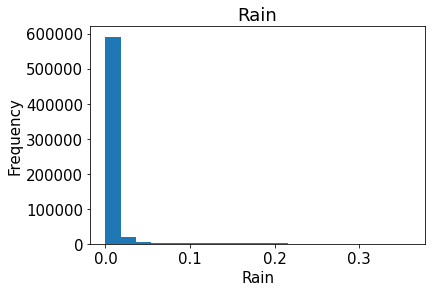

In [55]:
plt.title(r'Rain')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Rain'], bins = 20)
plt.xlabel('Rain')
plt.ylabel('Frequency')
plt.show

In [56]:
res_rain = df.Rain.quantile([lower_bound, upper_bound])

In [57]:
# Remove the observations larger than upper_bound.
true_index_rain = (df.Rain.values < res_rain.loc[upper_bound])

<function matplotlib.pyplot.show(close=None, block=None)>

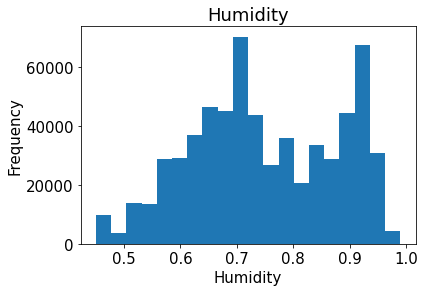

In [58]:
plt.title(r'Humidity')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Humidity'], bins = 20)
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.show

In [59]:
res_humidity = df.Humidity.quantile([lower_bound, upper_bound])

In [60]:
# Remove the observations smaller than lower_bound.
true_index_humidity = (res_humidity.loc[lower_bound] < df.Humidity.values)

<function matplotlib.pyplot.show(close=None, block=None)>

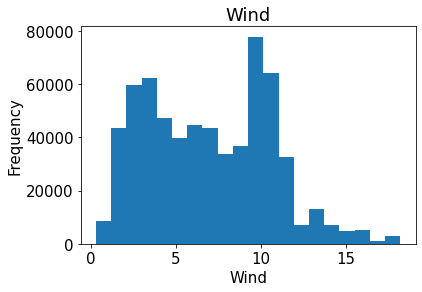

In [61]:
plt.title(r'Wind')
plt.rc('figure', titlesize = 40)
plt.rc('font', size = 15)
plt.hist(df['Wind'], bins = 20)
plt.xlabel('Wind')
plt.ylabel('Frequency')
plt.show

In [62]:
res_wind = df.Wind.quantile([lower_bound, upper_bound])

In [63]:
# Remove the observations larger than upper_bound.
true_index_wind = (df.Wind.values < res_wind.loc[upper_bound])

In [64]:
for i in range(df.shape[0]):
    if true_index_price[i] * true_index_distance[i] * true_index_temp[i] * true_index_clouds[i] * true_index_rain[i] * true_index_humidity[i] * true_index_wind[i] == 0:
        true_index_price[i] = False

true_index_price

array([ True,  True, False, ...,  True,  True,  True])

In [65]:
df = df[true_index_price]

## 2. Remove missing values.

In [66]:
df = df.dropna()

## 3. Scaling Features

In [67]:
# Feature Scaling to avoid the cases in which a feature with the largest scale dominates variations.
# Copy the original before scaling.
df_prescaled = df.copy()
# Remove features which do not need scaling.
df_scaled = df.drop(['Price', 'CabTypeName', 'ProductName', 'Source_ID', 'Destination_ID', 'Day', 'Hour'], axis = 1)

In [68]:
# Apply scaling.
from sklearn.preprocessing import scale

df_scaled = scale(df_scaled)

# Convert the object which is returned by scaling function into DataFrame
cols = df.columns.tolist()

for i in ['Price', 'CabTypeName', 'ProductName', 'Source_ID', 'Destination_ID', 'Day', 'Hour']:
    cols.remove(i)
df_scaled = pd.DataFrame(df_scaled, columns = cols, index = df.index)
df_scaled = pd.concat([df_scaled, df[['Price', 'CabTypeName', 'ProductName', 'Source_ID', 'Destination_ID', 'Day', 'Hour']]], axis = 1)
df = df_scaled.copy()

## 4. Encoding

In [69]:
# One-Hot Encoding
from sklearn.preprocessing import LabelBinarizer

In [70]:
df['CabTypeName'].replace({'Lyft': 0, 'Uber': 1}, inplace = True)

In [71]:
productname = LabelBinarizer().fit_transform(df.ProductName)
source_id = LabelBinarizer().fit_transform(df.Source_ID)
destination_id = LabelBinarizer().fit_transform(df.Destination_ID)
day = LabelBinarizer().fit_transform(df.Day)

In [72]:
df['Hour'] = df['Hour'].astype(int)

In [73]:
df.drop(['ProductName', 'Source_ID', 'Destination_ID', 'Day'], axis = 1, inplace = True)

In [74]:
# Encoding product names (One-hot encoding)
df['PN_1'] = productname[:, 0]
df['PN_2'] = productname[:, 1]
df['PN_3'] = productname[:, 2]
df['PN_4'] = productname[:, 3]
df['PN_5'] = productname[:, 4]
df['PN_6'] = productname[:, 5]
df['PN_7'] = productname[:, 6]
df['PN_8'] = productname[:, 7]
df['PN_9'] = productname[:, 8]
df['PN_10'] = productname[:, 9]
df['PN_11'] = productname[:, 10]
df['PN_12'] = productname[:, 11]

In [75]:
# Encoding starting points (One-hot encoding)
df['START_1'] = source_id[:, 0]
df['START_2'] = source_id[:, 1]
df['START_3'] = source_id[:, 2]
df['START_4'] = source_id[:, 3]
df['START_5'] = source_id[:, 4]
df['START_6'] = source_id[:, 5]
df['START_7'] = source_id[:, 6]
df['START_8'] = source_id[:, 7]
df['START_9'] = source_id[:, 8]
df['START_10'] = source_id[:, 9]
df['START_11'] = source_id[:, 10]
df['START_12'] = source_id[:, 11]

In [76]:
# Encoding destination locations (One-hot encoding)
df['DEST_1'] = destination_id[:, 0]
df['DEST_2'] = destination_id[:, 1]
df['DEST_3'] = destination_id[:, 2]
df['DEST_4'] = destination_id[:, 3]
df['DEST_5'] = destination_id[:, 4]
df['DEST_6'] = destination_id[:, 5]
df['DEST_7'] = destination_id[:, 6]
df['DEST_8'] = destination_id[:, 7]
df['DEST_9'] = destination_id[:, 8]
df['DEST_10'] = destination_id[:, 9]
df['DEST_11'] = destination_id[:, 10]
df['DEST_12'] = destination_id[:, 11]

In [77]:
# Encoding days of week  (One-hot encoding)
df['Day_1'] = day[:, 0]
df['Day_2'] = day[:, 1]
df['Day_3'] = day[:, 2]
df['Day_4'] = day[:, 3]
df['Day_5'] = day[:, 4]
df['Day_6'] = day[:, 5]
df['Day_7'] = day[:, 6]

## 5. Divide the preprocessed data into training and test sets.

In [78]:
# Set features and the target variable.
X = df.loc[:, df.columns != 'Price']
y = df.loc[:, 'Price']

In [79]:
# Divide the data set into training and test data sets.
# Training:Test = 0.8:0.2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Deep Neural Network
---

## 1. Model Architecture

In [80]:
## Deep Forward Network
# the number of hidden layers' nodes: 128
# The number of nodes is halved through the layer.
# activation function in hidden layers: ReLU (not in the output layer)
# loss function: MSE

# Build the model using Keras.
# Build the Sequential model based on our architecture.
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))

model.summary() # for model validation before starting training (must be the same as our model architecture)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6912      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 17,521
Trainable params: 17,521
Non-trainable params: 0
_________________________________________________________________


## 2. Training

In [81]:
# Compile the neural network and train it using our training data set.
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
14527/14527 [==============================] - 24s 788us/step - loss: 10.2560 - mse: 10.2560
Epoch 2/10
14527/14527 [==============================] - 12s 802us/step - loss: 4.1454 - mse: 4.1454
Epoch 3/10
14527/14527 [==============================] - 12s 795us/step - loss: 4.0308 - mse: 4.0308
Epoch 4/10
14527/14527 [==============================] - 12s 832us/step - loss: 4.0144 - mse: 4.0144
Epoch 5/10
14527/14527 [==============================] - 12s 797us/step - loss: 3.9252 - mse: 3.9252
Epoch 6/10
14527/14527 [==============================] - 11s 789us/step - loss: 3.9520 - mse: 3.9520
Epoch 7/10
14527/14527 [==============================] - 12s 801us/step - loss: 3.9235 - mse: 3.9235
Epoch 8/10
14527/14527 [==============================] - 12s 798us/step - loss: 3.8663 - mse: 3.8663
Epoch 9/10
14527/14527 [==============================] - 12s 803us/step - loss: 3.8702 - mse: 3.8702
Epoch 10/10
14527/14527 [==============================] - 12s 798us/step - loss

## 3. Evaluation

In [82]:
import numpy as np

In [83]:
# RMSE of the training and test data sets
from sklearn.metrics import mean_squared_error
 
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
 
test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
 
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 1.97
Test RMSE: 1.99
